# TP 1 Matthieu Boyer

## Exercice 3

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For testing and reproducibility:
random.seed(61843) # It's prime!

In [2]:
def generate_observations(N: int):
    points = np.zeros((N,3), dtype=float) # Store data points as 3-d tensor whose data is (x, y, label)
    for i in range(N):
        # Generate a pseudo random point in R^{2} as two numbers in $\R \cap [-1/2, 1/2]$.
        # We need finite precision to be able to compute the result. We could multiply to get a
        # larger set of points.
        px = (random.random() - 1/2)
        py = (random.random() - 1/2)
        points[i, :] = np.array([px, py, 0])

    # Generate hyperplane as direction of a normal vector:
    hx = (random.random() - 1/2)
    hy = (random.random() - 1/2)
    h = np.array([hx, hy, 0])

    for i in range(N):
        # Compute the sign of the dot product between point and hyperplane normal as float
        points[i, 2] = np.sign(np.dot(h, points[i,:]))
    return points, h

DATASET_SIZE = 100
DATASET, HYPERPLANE = generate_observations(100)

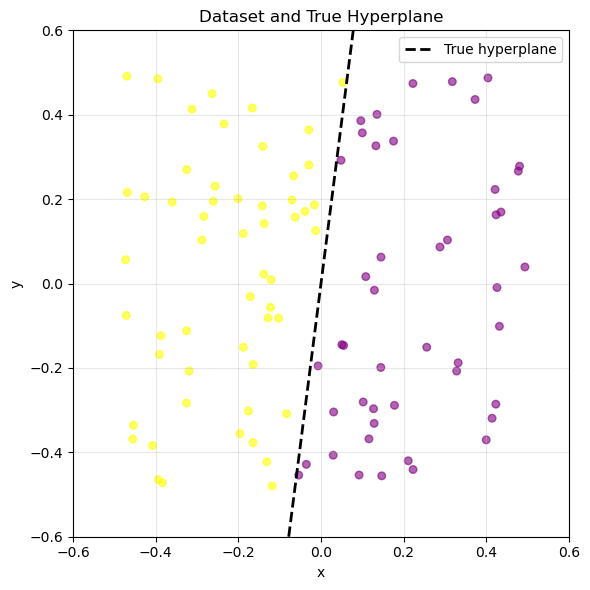

In [56]:
def get_colour(c):
    if c > 0:
        return "purple"
    return "yellow"

def plot_dataset(dataset, hyperplane):
    """
    Plot the dataset with the true hyperplane.
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    
    x = [p[0] for p in dataset]
    y = [p[1] for p in dataset]
    colours = [get_colour(p[2]) for p in dataset]

    ax.axline((0., 0.), (hyperplane[1], -hyperplane[0]), ls='--', 
              color='black', linewidth=2, label='True hyperplane')
    ax.scatter(x=x, y=y, color=colours, alpha=0.6, s=30)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Dataset and True Hyperplane')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.6, 0.6)
    ax.set_ylim(-0.6, 0.6)
    
    plt.tight_layout()
    plt.show()

plot_dataset(DATASET, HYPERPLANE)

### Question 2

On reprend l'algorithme de descente de gradient stochastique classique:
Étant donné un vecteur initial $w$ et un biais $\tau$ (qu'on regroupe sous un même vecteur $w_{0}$), ainsi qu'un pas de d'apprentissage $\eta$, on va effectuer les étapes suivantes jusqu'à ce qu'un minimum nous convienne (avec une limite de précision $\epsilon$ sur $k$ étapes de suite, par exemple, ou après $n_{max}$ étapes):

1. On tire un point $(\bar{x_{i}}, y_{i})$ dans le jeu de données d'entraînement.
2. On recalcule $w^{n + 1} = w^{n} + 2\eta(y_{i} - \langle w^{n} \mid \bar{x_{i}}\rangle\bar{x_{i}}$

Ici le changement de signe dans la formule de mise à jour de $w$ vient du signe du gradient.

### Question 3

In [23]:
def normalize_vector(w):
    """Normalize the weight vector"""
    w_norm = w.copy()
    norm = np.linalg.norm(w[:2])
    if norm > 0:
        w_norm[:2] = w_norm[:2] / norm
    return w_norm


def angle(w1, w2):
    """Calculate angle between two weight vectors (in degrees)."""
    w1_norm = normalize_vector(w1)
    w2_norm = normalize_vector(w2)
    
    # Only consider the weight components (not bias)
    cos_angle = np.dot(w1_norm[:2], w2_norm[:2])
    cos_angle = np.clip(cos_angle, -1, 1)
    angle = np.arccos(cos_angle) * 180 / np.pi
    
    return angle

In [79]:
def loss(w, dataset):
    # compute mean squared error loss
    X = dataset[:, :2]
    y = dataset[:, 2]

    # Increase size of vectors to take \tau into account
    X = np.column_stack([X, np.ones(len(X))])
    # Compute predictions
    predictions = X @ w
    loss = np.mean((y - predictions ** 2))

    return loss

def sgd_train(dataset, learning_rate=0.01, max_epochs=50, verbose=True):
    N = len(dataset)
    # Initialize random weights
    w = np.random.randn(3) * 0.1
    loss_history = []

    # We choose a max number of epochs for termination, instead of threshold computation
    for epoch in range(max_epochs): 
        # Sampling step
        sample_idx = np.random.randint(0, dataset.shape[0])
        sample = dataset[sample_idx, :]
        # Extending the vector
        x_bar_i = np.array([sample[0], sample[1], 1.0])
        label_i = sample[2]
        
        # Gradient prediction step
        y_hat = w @ x_bar_i
        error = label_i - y_hat
        
        # Update w <- w - 2 * eta * gradient
        w = w + 2 * learning_rate * error * x_bar_i

        loss_history.append(loss(w, dataset))

    return w, loss_history

def visualize_results(dataset, w_star, w_hat, loss_history):
    """
    Visualize the dataset, decision boundaries, and training progress.
    """
    print(f"\nTrue w*:      {w_star}")
    print(f"Estimated ŵ:  {w_hat}")
    print(f"Absolute angle between boundaries (in degrees): {angle(w_star, w_hat):3f}")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Data and decision boundaries
    ax1 = axes[0]
    
    # Separate classes
    x = dataset[:, 0]
    y = dataset[:, 1]
    colours = [get_colour(label) for label in dataset[:, 2]]
    
    ax1.scatter(x, y, c=colours, alpha=0.6, s=30)
    
    # Plot decision boundaries
    x_line = np.linspace(-.5, .5, 100)
    
    # Plot true boundary:
    ax1.axline((0, 0), (w_star[1], -w_star[0]), linewidth=2, label='True w*', ls="--", color="black")
    
    # Estimated boundary
    ax1.axline((0, 0), (w_hat[1], -w_hat[0]), linewidth=2, label='Estimated ŵ', ls="solid", color="green")
    
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Dataset and Decision Boundaries')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(-.6, .6)
    ax1.set_ylim(-.6, .6)
    
    # Plot 2: Loss history
    ax2 = axes[1]
    ax2.plot(range(1, len(loss_history) + 1), loss_history, 'b-', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss (MSE)')
    ax2.set_title('Training Loss over Epochs')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


True w*:      [ 0.30182188 -0.03928076  0.        ]
Estimated ŵ:  [ 1.68557166 -0.34160365  0.03614046]
Absolute angle between boundaries (in degrees): 4.041478


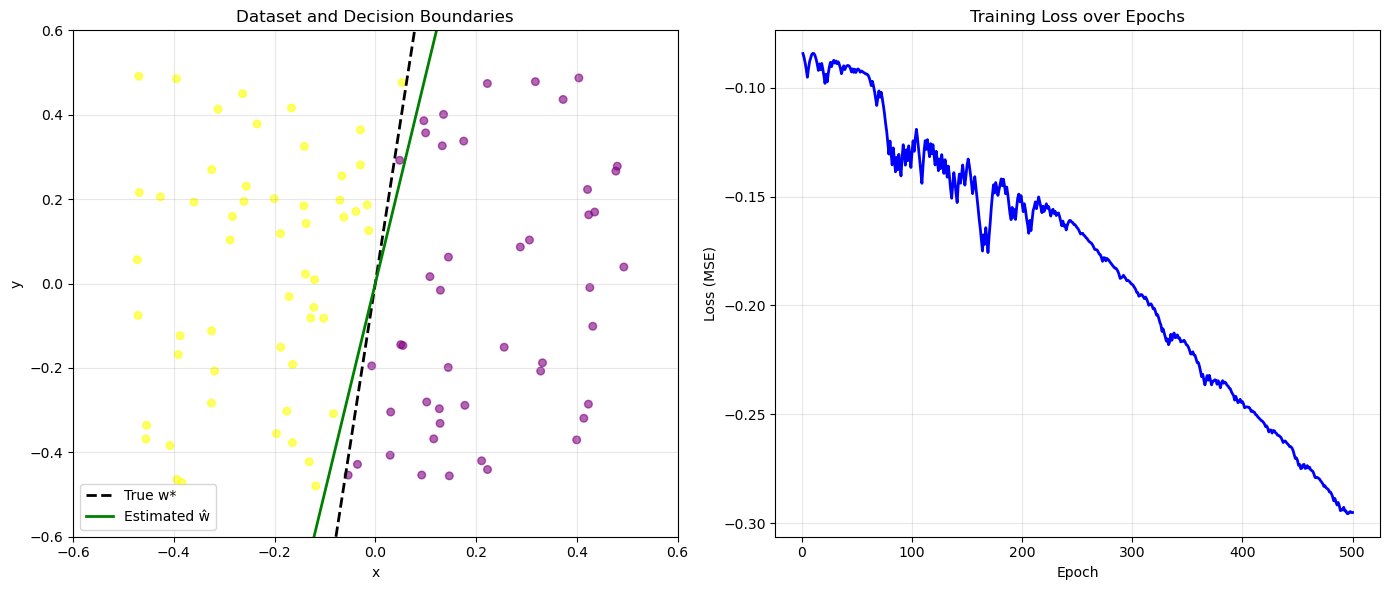

In [80]:
w_hat, loss_history = sgd_train(DATASET, learning_rate=0.01, max_epochs=500, verbose=True)
visualize_results(DATASET, HYPERPLANE, w_hat, loss_history)

## Question 4

In [81]:
def add_gaussian_noise(dataset, noise_std=0.1):
    noisy_dataset = dataset.copy() # Copy dataset to modify it
    
    # Add Gaussian noise with noise_std deviation to x and y coordinates
    noise = np.random.randn(len(dataset), 2) * noise_std # Generate samples from univariate distribution and multiply by standard deviation
    noisy_dataset[:, :2] += noise
    
    return noisy_dataset

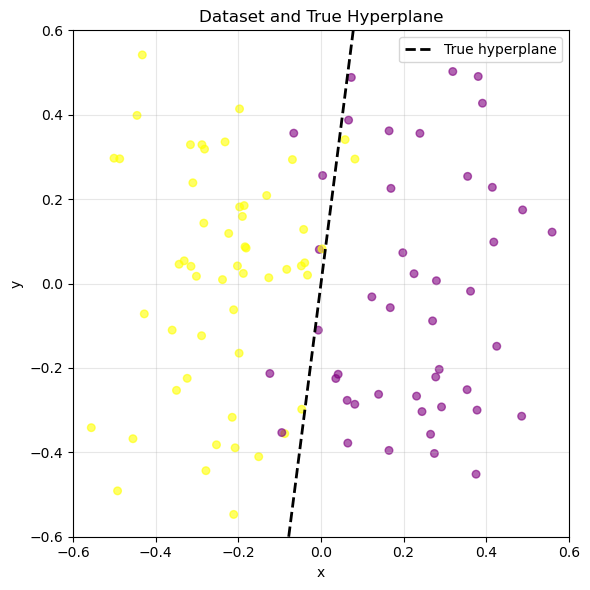

In [82]:
NOISY_DATASET = add_gaussian_noise(DATASET)
plot_dataset(NOISY_DATASET, HYPERPLANE)


True w*:      [ 0.30182188 -0.03928076  0.        ]
Estimated ŵ:  [ 1.54946124 -0.19105766 -0.04868224]
Absolute angle between boundaries (in degrees): 0.385687


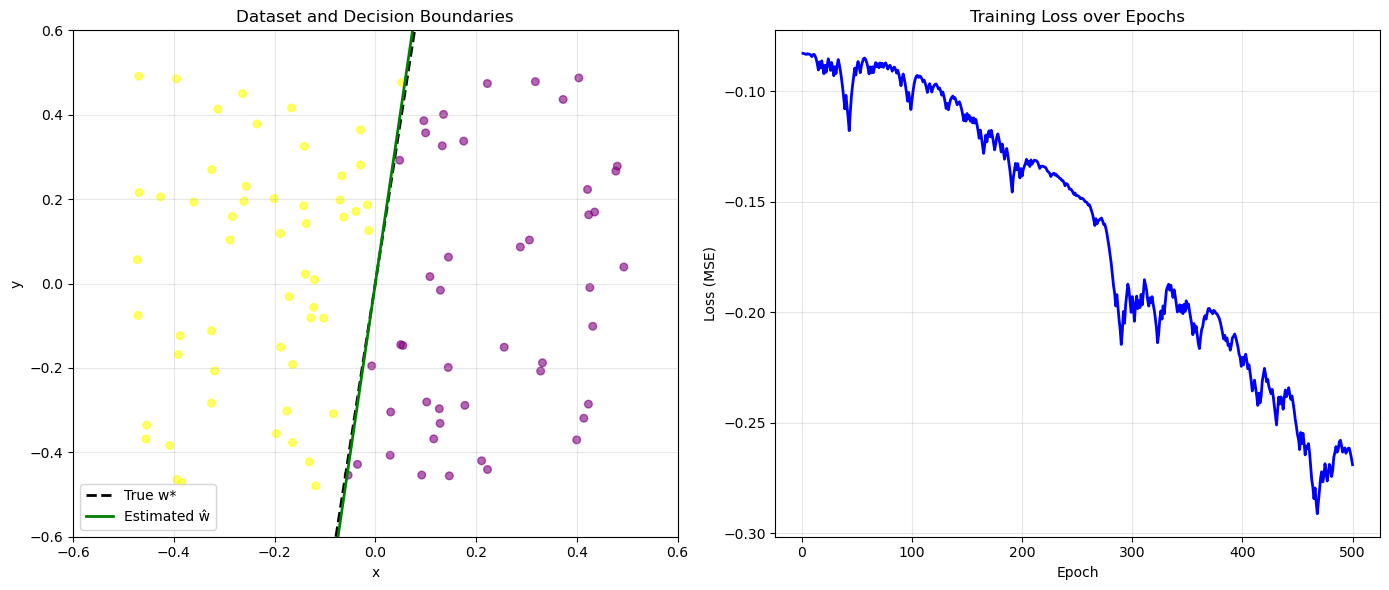

In [83]:
noisy_w_hat, noisy_loss_history = sgd_train(NOISY_DATASET, learning_rate=0.01, max_epochs=500, verbose=True)
visualize_results(DATASET, HYPERPLANE, noisy_w_hat, noisy_loss_history)

## Question 5

In [101]:
def load_heart_disease_data():
    """
    Load and preprocess the Heart Disease dataset from UCI repository.
    Uses the Cleveland dataset which is most commonly used.
    """
    import urllib.request
    import io
    
    # URL for heart dataset
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
    
    print("\nDownloading Heart Disease dataset from UCI repository...")
    try:
        # Download and parse
        response = urllib.request.urlopen(url)
        data = response.read().decode('utf-8')
        lines = data.strip().split('\n')
        dataset = []
        
        for line in lines:
            if line.strip():
                values = line.split(',')
                values = [float(v) if v != '?' else np.nan for v in values]
                dataset.append(values)
        
        dataset = np.array(dataset)
        dataset = dataset[~np.isnan(dataset).any(axis=1)]
        
        print(f"✓ Successfully loaded {len(dataset)} samples")
        print(f"  Original features: {dataset.shape[1] - 1}")
        
        return dataset
        
    except Exception as e:
        print(f"✗ Error loading data: {e}")
        return dataset

def preprocess_heart_data(dataset, use_pca=True, n_components=2):
    """
    Preprocess the heart disease dataset.
    
    Args:
        dataset: raw dataset
        use_pca: whether to use PCA for dimensionality reduction
        n_components: number of components to keep (for 2D visualization)
    
    Returns:
        processed_dataset: (N, 3) array with (x, y, label)
    """
    # Separate features and labels
    X = dataset[:, :-1]  # All columns except last
    y = dataset[:, -1]   # Last column (diagnosis)
    
    # Convert to binary classification: 0 = no disease, >0 = disease
    y_binary = (y > 0).astype(float) * 2 - 1  # Convert to {-1, +1}
    
    # Standardize features
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X_std[X_std == 0] = 1  # Avoid division by zero
    X_normalized = (X - X_mean) / X_std
    
    # Simple PCA implementation for dimensionality reduction
    X_centered = X_normalized - np.mean(X_normalized, axis=0)
    
    # Compute covariance matrix
    cov_matrix = np.cov(X_centered.T)
    
    # Compute sorted eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Select top n_components
    components = eigenvectors[:, :n_components]
    
    # Project data
    X_reduced = X_centered @ components
    
    explained_var = np.sum(eigenvalues[:n_components]) / np.sum(eigenvalues)
    
    # Create dataset in format (x, y, label)
    processed_dataset = np.column_stack([X_reduced, y_binary])
    
    return processed_dataset

In [102]:
HEART_DATASET = load_heart_disease_data()


✓ Successfully loaded 297 samples
  Original features: 13


In [103]:
HEART_DATASET = preprocess_heart_data(HEART_DATASET, use_pca=True, n_components=2)


True w*:      [0.  0.1]
Estimated ŵ:  [ 0.31059644 -0.1077628  -0.1446461 ]
Absolute angle between boundaries (in degrees): 109.134443


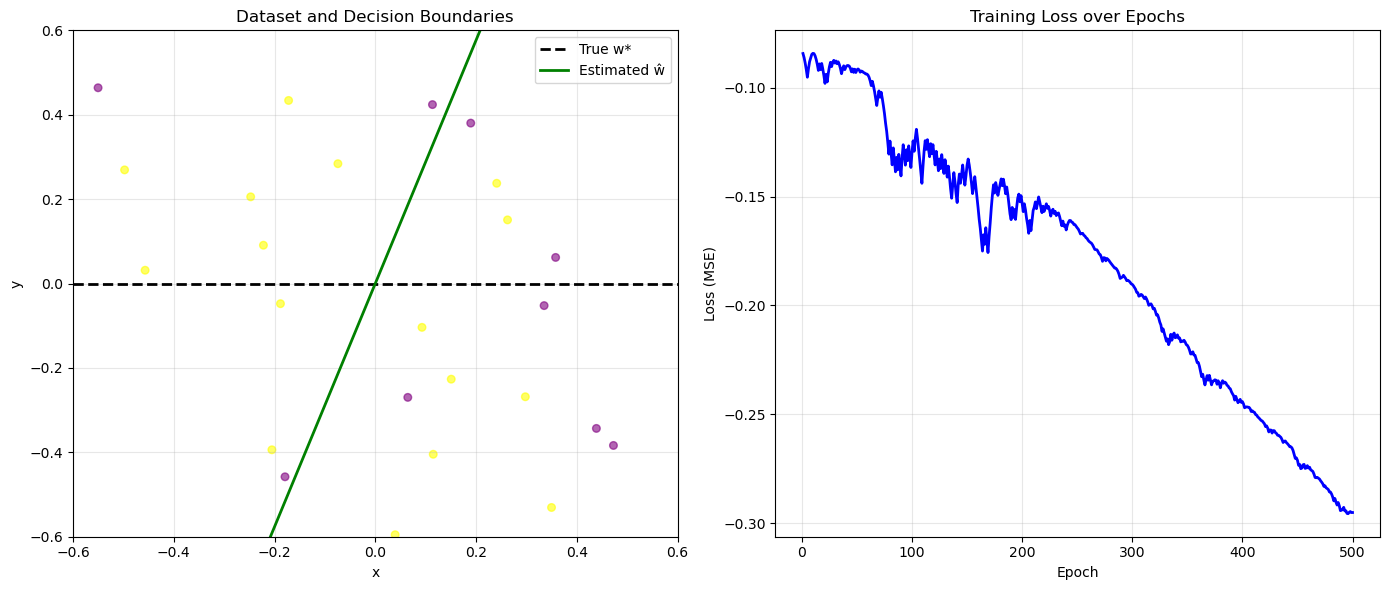

In [106]:
heart_w_hat, heart_loss_history = sgd_train(HEART_DATASET, learning_rate=0.01, max_epochs=500, verbose=True)
visualize_results(HEART_DATASET, np.array([0, 0.1]), heart_w_hat, loss_history)